# **Preprocessing: MLP Projection & Feature Alignment**

Notebook ini bertujuan untuk memproses fitur mentah (Audio, Lirik, MIDI) menjadi representasi vektor yang seragam (Common Embedding Space) dan menyelaraskan urutan datanya.

Berikut link dataset, beserta extraksi file per modalitas:

https://drive.google.com/drive/folders/1LFAWbmzrsFAxiMhYHPkFdWIkRaIkBgvH

**1. Konfigurasi & Inisialisasi**

Bagian ini mengatur parameter utama, menghubungkan Google Drive, dan mengimpor pustaka yang diperlukan.

**CATATAN UNTUK TIM FUSION:** Jika Anda ingin mengubah dimensi output embedding (misalnya menjadi 512 atau 128), silakan ubah nilai variabel TARGET_DIM pada blok konfigurasi di bawah ini sebelum menjalankan kode.

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Environment
FEATURE_DIR = 'Extracted_Feature'

# --- KONFIGURASI MODEL ---
CONFIG = {
    'target_dim': 256,       # <--- UBAH DI SINI (Misal: 512, 128)
    'dropout': 0.3,          # Rate dropout untuk regularisasi
    'use_layer_norm': True,  # Wajib True untuk kestabilan Fusion
    'save_dir': 'ready_for_fusion'
}

if not os.path.exists(CONFIG['save_dir']):
    os.makedirs(CONFIG['save_dir'])

print(f"Konfigurasi aktif. Target Dimensi: {CONFIG['target_dim']}")
print(f"Folder penyimpanan: {CONFIG['save_dir']}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Konfigurasi aktif. Target Dimensi: 256
Folder penyimpanan: /content/drive/MyDrive/dataset/ready_for_fusion


**2. Memuat Data Fitur Mentah**

Bagian ini membaca file fitur hasil ekstraksi (.npy untuk Audio, .pkl untuk Lirik/MIDI) dari Google Drive ke dalam memori.

In [ ]:
print("Memulai proses pemuatan data...")

# Container untuk menyimpan data
raw_data = {'audio': {}, 'lyrics': pd.DataFrame(), 'midi': pd.DataFrame()}

# 1. Load Audio
try:
    audio_path = os.path.join(FEATURE_DIR, 'audio_features.npy')
    data = np.load(audio_path, allow_pickle=True)
    if data.ndim == 0: data = data.item()
    raw_data['audio'] = data
    print(f"- Audio loaded: {len(data)} sampel")
except Exception as e:
    print(f"! Gagal memuat Audio: {e}")

# 2. Load Lyrics
try:
    lyrics_path = os.path.join(FEATURE_DIR, 'bert_features_lyrics.pkl')
    raw_data['lyrics'] = pd.read_pickle(lyrics_path)
    print(f"- Lyrics loaded: {len(raw_data['lyrics'])} sampel")
except Exception as e:
    print(f"! Gagal memuat Lirik: {e}")

# 3. Load MIDI
try:
    midi_path = os.path.join(FEATURE_DIR, 'midi_features_remi.pkl')
    raw_data['midi'] = pd.read_pickle(midi_path)
    print(f"- MIDI loaded: {len(raw_data['midi'])} sampel")
except Exception as e:
    print(f"! Gagal memuat MIDI: {e}")

Memulai proses pemuatan data dari Drive...
! Gagal memuat Audio: [Errno 2] No such file or directory: '/content/drive/MyDrive/dataset/audio_features.npy'
! Gagal memuat Lirik: [Errno 2] No such file or directory: '/content/drive/MyDrive/dataset/bert_features_lyrics.pkl'
! Gagal memuat MIDI: [Errno 2] No such file or directory: '/content/drive/MyDrive/dataset/midi_features_remi.pkl'


**3. Penyelarasan Data (Alignment) & Visualisasi Kelengkapan**

Bagian ini menyinkronkan urutan data agar konsisten berdasarkan song_id.
*   Strategi Union: Mengambil semua ID lagu yang tersedia di salah satu modalitas.

* Zero Padding: Jika data hilang pada modalitas tertentu, akan diisi dengan vektor nol.

* Masking: Membuat tensor penanda (1=Valid, 0=Padding) agar model Fusion dapat mengabaikan data kosong.

Visualisasi: Output di bawah akan menampilkan grafik batang yang membandingkan jumlah data valid vs data kosong (missing) untuk setiap modalitas.


In [ ]:
def align_data_union(data_container):
    print("\nMenjalankan proses penyelarasan data (Union Strategy)...")

    # 1. Identifikasi ID Unik (Gabungan dari semua modalitas)
    ids_audio = set([k.replace('.mp3', '') for k in data_container['audio'].keys()])
    ids_lyrics = set(data_container['lyrics']['song_id'].astype(str).values) if not data_container['lyrics'].empty else set()
    ids_midi = set(data_container['midi']['song_id'].astype(str).values) if not data_container['midi'].empty else set()

    all_ids = sorted(list(ids_audio | ids_lyrics | ids_midi))

    # 2. Persiapan Dimensi untuk Zero Padding
    # Mengambil sampel data pertama untuk mengetahui ukuran vektor aslinya
    dim_aud = next(iter(data_container['audio'].values())).shape[0] if ids_audio else 0
    dim_lyr = data_container['lyrics']['bert_features'].iloc[0].shape[0] if not data_container['lyrics'].empty else 0
    dim_mid = data_container['midi']['midi_features'].iloc[0].shape[0] if not data_container['midi'].empty else 0

    # Helper Dictionary untuk akses cepat
    lyric_map = dict(zip(data_container['lyrics']['song_id'].astype(str), data_container['lyrics']['bert_features'])) if not data_container['lyrics'].empty else {}
    midi_map = dict(zip(data_container['midi']['song_id'].astype(str), data_container['midi']['midi_features'])) if not data_container['midi'].empty else {}

    # Container Hasil
    aligned = {'audio': [], 'lyrics': [], 'midi': []}
    masks = {'audio': [], 'lyrics': [], 'midi': []}

    # 3. Loop Alignment
    for sid in all_ids:
        # Audio
        key = f"{sid}.mp3" if f"{sid}.mp3" in data_container['audio'] else sid
        if key in data_container['audio']:
            aligned['audio'].append(data_container['audio'][key])
            masks['audio'].append(1)
        else:
            aligned['audio'].append(np.zeros(dim_aud))
            masks['audio'].append(0)

        # Lyrics
        if sid in lyric_map:
            aligned['lyrics'].append(lyric_map[sid])
            masks['lyrics'].append(1)
        else:
            aligned['lyrics'].append(np.zeros(dim_lyr))
            masks['lyrics'].append(0)

        # MIDI
        if sid in midi_map:
            aligned['midi'].append(midi_map[sid])
            masks['midi'].append(1)
        else:
            aligned['midi'].append(np.zeros(dim_mid))
            masks['midi'].append(0)

    # Convert List ke PyTorch Tensor
    tensors = {k: torch.tensor(np.stack(v), dtype=torch.float32) for k, v in aligned.items()}
    mask_tensors = {k: torch.tensor(v, dtype=torch.float32) for k, v in masks.items()}

    return tensors, mask_tensors, all_ids

# --- EKSEKUSI & VISUALISASI ---
inputs, masks, song_ids = align_data_union(raw_data)

# Visualisasi Data Availability
modalities = ['Audio', 'Lyrics', 'MIDI']
valid_counts = [masks['audio'].sum().item(), masks['lyrics'].sum().item(), masks['midi'].sum().item()]
total_samples = len(song_ids)
missing_counts = [total_samples - x for x in valid_counts]

plt.figure(figsize=(10, 5))
plt.bar(modalities, valid_counts, label='Data Tersedia (Valid)', color='#2ca02c')
plt.bar(modalities, missing_counts, bottom=valid_counts, label='Data Kosong (Padding)', color='#d62728')
plt.ylabel('Jumlah Sampel')
plt.title(f'Statistik Kelengkapan Data per Modalitas (Total: {total_samples} Lagu)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print(f"Dimensi Input Awal: Audio={inputs['audio'].shape[1]}, Lirik={inputs['lyrics'].shape[1]}, MIDI={inputs['midi'].shape[1]}")


Menjalankan proses penyelarasan data (Union Strategy)...


ValueError: need at least one array to stack

**4. Konstruksi Model MLP & Proyeksi**

Bagian ini mendefinisikan arsitektur jaringan saraf (ProjectorMLP) dan menjalankan proses proyeksi data.

Detail Arsitektur:
* Linear: Mengompresi dimensi input.

* LayerNorm: Menormalkan distribusi angka untuk kestabilan training.

* GELU: Fungsi aktivasi modern.

* Linear: Proyeksi akhir ke TARGET_DIM (256).


In [ ]:
class ProjectorMLP(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super(ProjectorMLP, self).__init__()

        # Layer tengah (Hidden Dimension)
        hidden_dim = (input_dim + output_dim) // 2

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim) if config['use_layer_norm'] else nn.Identity(),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            # Layer akhir ke Target Dimension
            nn.Linear(hidden_dim, output_dim),
            nn.LayerNorm(output_dim) if config['use_layer_norm'] else nn.Identity()
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight)
            if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

def run_projection(inputs, config):
    print(f"\nMemulai proses proyeksi ke {config['target_dim']} dimensi...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Menggunakan processing unit: {device}")

    # Init Model & Container
    models = {}
    embeddings = {}

    # Loop untuk setiap modalitas
    for mod in ['audio', 'lyrics', 'midi']:
        input_dim = inputs[mod].shape[1]

        # Membangun model spesifik untuk modalitas ini
        models[mod] = ProjectorMLP(input_dim, config['target_dim'], config).to(device)
        models[mod].eval() # Mode inferensi (tanpa update gradien)

        # Proses Data
        with torch.no_grad():
            data_in = inputs[mod].to(device)
            embeddings[mod] = models[mod](data_in).cpu()

    print("Proyeksi selesai untuk semua modalitas.")
    return embeddings

# Eksekusi
embeddings = run_projection(inputs, CONFIG)

NameError: name 'inputs' is not defined

**5. Validasi & Visualisasi Distribusi**

Bagian ini memeriksa kualitas embedding yang dihasilkan. Visualisasi: Kode akan menampilkan histogram distribusi nilai embedding. Kurva yang berbentuk lonceng (Gaussian) dengan rata-rata mendekati 0 menandakan data sudah ternormalisasi dengan baik dan siap untuk Fusion.


   LAPORAN KUALITAS DISTRIBUSI DATA

📊 Modalitas: AUDIO
   - Jumlah Sampel Valid : 903
   - Rata-rata (Mean)    : 0.0000 (Ideal: ~0.00)
   - Sebaran (Std Dev)   : 1.0000  (Ideal: ~1.00)
   - Status: ✅ DATA SEHAT (Normal)

📊 Modalitas: LYRICS
   - Jumlah Sampel Valid : 764
   - Rata-rata (Mean)    : -0.0000 (Ideal: ~0.00)
   - Sebaran (Std Dev)   : 1.0000  (Ideal: ~1.00)
   - Status: ✅ DATA SEHAT (Normal)

📊 Modalitas: MIDI
   - Jumlah Sampel Valid : 194
   - Rata-rata (Mean)    : -0.0000 (Ideal: ~0.00)
   - Sebaran (Std Dev)   : 1.0000  (Ideal: ~1.00)
   - Status: ✅ DATA SEHAT (Normal)


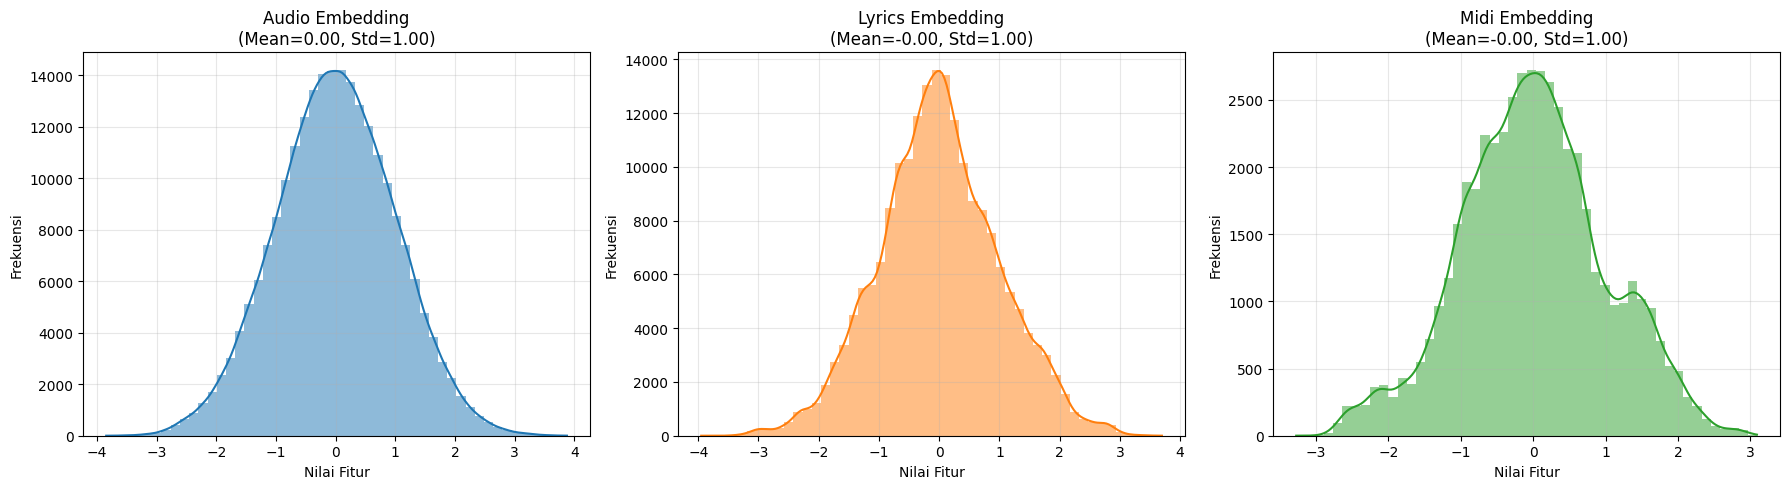

In [ ]:
def validate_and_visualize(embeddings, masks):
    print("\n" + "="*40)
    print("   LAPORAN KUALITAS DISTRIBUSI DATA")
    print("="*40)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, mod in enumerate(['audio', 'lyrics', 'midi']):
        # Hanya ambil data valid (Mask = 1) untuk analisis yang akurat
        valid_idx = torch.where(masks[mod] == 1)[0]

        if len(valid_idx) == 0:
            print(f"\n⚠️ Peringatan: Tidak ada data valid untuk modalitas {mod.upper()}")
            continue

        data = embeddings[mod][valid_idx].flatten().numpy()

        # Hitung Statistik
        mean, std = np.mean(data), np.std(data)

        # --- TEKS LOGGING ---
        print(f"\n📊 Modalitas: {mod.upper()}")
        print(f"   - Jumlah Sampel Valid : {len(valid_idx)}")
        print(f"   - Rata-rata (Mean)    : {mean:.4f} (Ideal: ~0.00)")
        print(f"   - Sebaran (Std Dev)   : {std:.4f}  (Ideal: ~1.00)")

        # Cek Kesehatan Data (Heuristik Sederhana)
        # LayerNorm biasanya membuat Mean di range -0.1 s.d 0.1 dan Std di 0.8 s.d 1.2
        if abs(mean) < 0.5 and 0.5 < std < 1.5:
            print("   - Status: ✅ DATA SEHAT (Normal)")
        else:
            print("   - Status: ⚠️ PERHATIAN (Distribusi agak bias, cek arsitektur MLP)")

        # --- PLOT HISTOGRAM ---
        sns.histplot(data, bins=50, ax=axes[i], color=colors[i], kde=True, edgecolor=None)
        axes[i].set_title(f"{mod.capitalize()} Embedding\n(Mean={mean:.2f}, Std={std:.2f})")
        axes[i].set_xlabel("Nilai Fitur")
        axes[i].set_ylabel("Frekuensi")
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

validate_and_visualize(embeddings, masks)

**6. Penyimpanan Hasil (Export)**

Bagian terakhir ini menyimpan tensor hasil proyeksi dan mask ke dalam Google Drive agar bisa langsung digunakan oleh tim Fusion.

File yang dihasilkan:

* emb_*.pt: Fitur utama.

* mask_*.pt: Data mask untuk handling missing value.

* song_ids.npy: Referensi urutan ID lagu.

In [ ]:
os.makedirs(CONFIG['save_dir'], exist_ok=True)
print(f"\nMenyimpan file hasil ke: {CONFIG['save_dir']}")

# Simpan Embeddings & Masks
for mod in ['audio', 'lyrics', 'midi']:
    # Simpan Embedding
    emb_path = os.path.join(CONFIG['save_dir'], f'emb_{mod}.pt')
    torch.save(embeddings[mod], emb_path)

    # Simpan Mask
    mask_path = os.path.join(CONFIG['save_dir'], f'mask_{mod}.pt')
    torch.save(masks[mod], mask_path)

    print(f"- {mod.capitalize()}: Saved.")

# Simpan ID Lagu
id_path = os.path.join(CONFIG['save_dir'], 'song_ids.npy')
np.save(id_path, song_ids)

print("\nProses selesai sepenuhnya.")


Menyimpan file hasil ke: /content/drive/MyDrive/dataset/ready_for_fusion
- Audio: Saved.
- Lyrics: Saved.
- Midi: Saved.

Proses selesai sepenuhnya.


ini untuk linknya: https://drive.google.com/drive/folders/1LFAWbmzrsFAxiMhYHPkFdWIkRaIkBgvH

Ringkasan Pengerjaan

Berikut adalah rekapitulasi dari proses yang dilakukan dalam notebook ini:



1.   Pemuatan Data: Data fitur mentah dari Cnn14 (Audio), BERT (Lirik), dan REMI (MIDI) berhasil dimuat.
2.   Alignment (Union): Seluruh song_id digabungkan. Data yang tidak lengkap diisi dengan Zero Padding dan ditandai menggunakan Mask Tensor. Grafik kelengkapan data ditampilkan pada Langkah 3.
3. Proyeksi Fitur: Fitur diproyeksikan ke dimensi seragam (default: 256) menggunakan MLP dengan normalisasi LayerNorm.

4. Validasi: Distribusi data hasil proyeksi telah divisualisasikan untuk memastikan integritas data (tidak ada collapse atau nilai ekstrem).

5. Ekspor: File .pt dan .npy tersimpan di folder ready_for_fusion.




Tindakan Selanjutnya untuk Fusion: Gunakan file emb_*.pt sebagai input dan mask_*.pt sebagai filter pada layer Attention/Fusion untuk menangani missing modality.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import re


In [ ]:

# ==========================================
# BAGIAN 1: PERSIAPAN DATA & LABEL
# ==========================================
print("\n=== PERSIAPAN FUSION ===")

# 1. Fungsi untuk Parsing Label dari File BAT (Sama seperti logika EDA)
def get_labels_aligned(dataset_path, sorted_song_ids):
    print("Mengambil label dari file .bat...")
    label_map = {}
    bat_files = [
        os.path.join(dataset_path, 'split-by-categories-audio.bat'),
        os.path.join(dataset_path, 'split-by-categories-lyrics.bat'),
        os.path.join(dataset_path, 'split-by-categories-midi.bat'),
    ]

    for b_file in bat_files:
        if os.path.exists(b_file):
            with open(b_file, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    # Regex: move filename "path/Cluster X/..."
                    m = re.search(r'move\s+([^\s]+)\s+"?([^"]+)"?', line, flags=re.IGNORECASE)
                    if m:
                        fname = os.path.basename(m.group(1))
                        sid = os.path.splitext(fname)[0] # ID Lagu
                        dest = m.group(2)
                        # Cari "Cluster X"
                        c_match = re.search(r'Cluster\s*(\d+)', dest, flags=re.IGNORECASE)
                        if c_match:
                            # Label diubah jadi 0-4 (karena PyTorch butuh 0-based index)
                            label_map[sid] = int(c_match.group(1)) - 1

    # 2. Menyelaraskan Label dengan Urutan ID dari MLP
    aligned_labels = []
    valid_indices = []

    for idx, sid in enumerate(sorted_song_ids):
        # Handle ID cleaning (misal 001 vs 1)
        sid_str = str(int(sid)) if sid.isdigit() else sid

        found = False
        # Coba cari exact match atau cleaned match
        if sid in label_map:
            aligned_labels.append(label_map[sid])
            valid_indices.append(idx)
        elif sid_str in label_map: # Coba cari versi integer stringnya
             # Update label_map key agar konsisten untuk next check
            aligned_labels.append(label_map[sid_str])
            valid_indices.append(idx)
        else:
            # Jika tidak ada label, data ini tidak bisa dipakai training
            pass

    return np.array(aligned_labels), valid_indices

# --- Eksekusi Load Label ---
# Menggunakan variabel 'song_ids' dari output MLP Projection sebelumnya
y_all, valid_idx = get_labels_aligned(dataset_path, song_ids)

# Filter Embedding agar hanya yang punya label
X_audio = embeddings['audio'][valid_idx]
X_lyrics = embeddings['lyrics'][valid_idx]
X_midi = embeddings['midi'][valid_idx]

# Filter Mask
M_audio = masks['audio'][valid_idx]
M_lyrics = masks['lyrics'][valid_idx]
M_midi = masks['midi'][valid_idx]

print(f"Data siap untuk Fusion: {len(y_all)} sampel (dari total {len(song_ids)})")




=== PERSIAPAN FUSION ===


NameError: name 'song_ids' is not defined

In [ ]:
# ==========================================
# BAGIAN 2: DATASET & SPLIT
# ==========================================

# Split Train/Test (80/20)
# Kita split index-nya saja untuk mempermudah slicing tensor
indices = np.arange(len(y_all))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y_all)

class MultimodalDataset(Dataset):
    def __init__(self, idxs, aud, lyr, mid, ma, ml, mm, labels):
        self.idxs = idxs
        self.aud = aud
        self.lyr = lyr
        self.mid = mid
        self.ma = ma
        self.ml = ml
        self.mm = mm
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        idx = self.idxs[i]
        return (
            self.aud[idx], self.lyr[idx], self.mid[idx], # Fitur
            self.ma[idx], self.ml[idx], self.mm[idx],    # Mask
            self.labels[idx]                             # Target
        )

train_dataset = MultimodalDataset(train_idx, X_audio, X_lyrics, X_midi, M_audio, M_lyrics, M_midi, y_all)
test_dataset = MultimodalDataset(test_idx, X_audio, X_lyrics, X_midi, M_audio, M_lyrics, M_midi, y_all)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
# ==========================================
# BAGIAN 3: MODEL INTERMEDIATE FUSION
# ==========================================

class AttentionFusion(nn.Module):
    def __init__(self, input_dim, num_classes=5, dropout=0.3):
        super(AttentionFusion, self).__init__()

        # 1. Attention Mechanism
        # Menghitung bobot kepentingan (score) untuk tiap modalitas
        self.attn_fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1) # Output skalar per modalitas
        )

        # 2. Classifier
        # Input dim tetap sama dengan input_dim karena kita pakai Weighted Sum, bukan Concatenation
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, a, l, m, ma, ml, mm):
        # a, l, m shape: (Batch, Dim)
        # Stack menjadi (Batch, 3, Dim)
        stacked = torch.stack([a, l, m], dim=1)

        # Stack masks: (Batch, 3, 1)
        masks = torch.stack([ma, ml, mm], dim=1).unsqueeze(-1)

        # Hitung Attention Scores: (Batch, 3, 1)
        scores = self.attn_fc(stacked)

        # Masking score (Modalitas kosong diberi skor sangat kecil agar Softmax ~ 0)
        # Kita ganti skor modalitas yang hilang menjadi -1e9
        scores = scores.masked_fill(masks == 0, -1e9)

        # Softmax untuk mendapatkan bobot (weights)
        weights = torch.softmax(scores, dim=1)

        # Weighted Sum: (Batch, 3, Dim) * (Batch, 3, 1) -> Sum dim 1 -> (Batch, Dim)
        fused_embedding = torch.sum(stacked * weights, dim=1)

        # Classification
        output = self.classifier(fused_embedding)
        return output



In [ ]:
# ==========================================
# BAGIAN 4: TRAINING
# ==========================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionFusion(input_dim=CONFIG['target_dim'], num_classes=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print(f"\nMemulai Training Fusion di {device}...")
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        # Unpack batch & pindah ke device
        aud, lyr, mid, ma, ml, mm, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(aud, lyr, mid, ma, ml, mm)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f} | Acc: {100 * correct / total:.2f}%")



In [ ]:
# ==========================================
# BAGIAN 5: EVALUASI
# ==========================================
print("\n=== HASIL EVALUASI ===")
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        aud, lyr, mid, ma, ml, mm, labels = [b.to(device) for b in batch]
        outputs = model(aud, lyr, mid, ma, ml, mm)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print Metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
# Target names disesuaikan dengan Cluster 1-5
print(classification_report(y_true, y_pred, target_names=[f'Cluster {i+1}' for i in range(5)]))

# Simpan Model Fusion
torch.save(model.state_dict(), os.path.join(CONFIG['save_dir'], 'fusion_model.pth'))
print("Model Fusion tersimpan.")